In [1]:
# import libraries 
import pandas as pd
import numpy as np
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn import metrics


import geopy
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

from vincenty import vincenty

from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

from sklearn.cluster import KMeans

from imblearn.over_sampling import SMOTE


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
from sklearn.svm import SVC
import sklearn.metrics
    
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import model_selection


C:\Users\erkin\miniconda3\envs\PDS20\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
warnings.filterwarnings("ignore")

In [65]:
df = pd.read_csv("../data/processed/dortmund_trips.csv", index_col = 0)

Text(0.5, 0, 'trip duration in minutes')

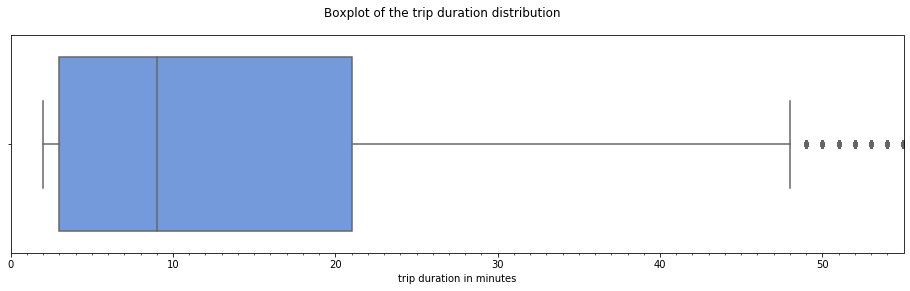

In [66]:
# check outliers
#identifiy outlier record based on trip duration
ax = plt.figure(figsize = (16,4))
ax.suptitle("Boxplot of the trip duration distribution", y=0.98)
ax = sns.boxplot (x=df["trip_duration"], color='cornflowerblue')
ax.set_xticks(np.arange(0, 55),1)
ax.set_xlim([0, 55]) 
ax.set_xlabel('trip duration in minutes')


Outlier: 2min<=trip<=48min

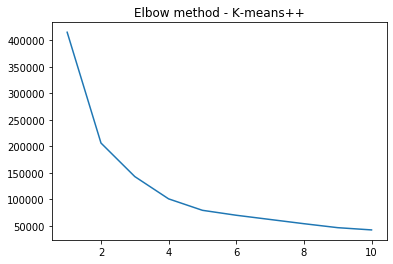

In [67]:
st_scaler = StandardScaler()
X_scaled = st_scaler.fit_transform(df[["latitude_start","longitude_start"]])

k_max = 10
clusters = []
losses = []

# elbow method to specify the appropriate number of cluster
for k in range(k_max):
    model = KMeans(n_clusters=k+1)
    model.fit(X_scaled)
    clusters.append(k+1)
    losses.append(model.inertia_)
    
plt.plot(clusters, losses)
plt.title("Elbow method - K-means++")
plt.show()


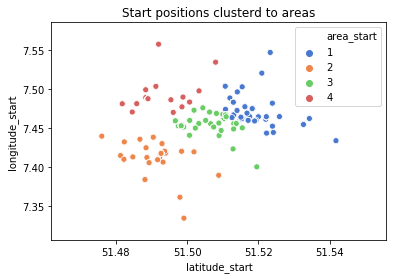

In [68]:
# due to the elbow method number of clusters are set to 4 
km = KMeans(n_clusters = 4)
km.fit(X_scaled)
df["area_start"] = km.predict(X_scaled)+1

sns.scatterplot(x="latitude_start", y="longitude_start", data=df, hue="area_start", palette="muted")
plt.title("Start positions clusterd to areas")
plt.show()

In [69]:
def make_point(row):
    return Point(row.longitude_start, row.latitude_start)


In [70]:
#these are currently the coordinates of TU Dortmund Hörsaalgebäude 2
def calculate_distanceToUniversity(row):
    university_center_lat = 51.492296
    university_center_lon = 7.41273 
    
    distance = vincenty([row["latitude_start"], row["longitude_start"]], [university_center_lat, university_center_lon],)
    
    return distance

In [71]:
# kann später weg, im master ist dieses attribut bereits 0/1 (hier war es noch True/False)
def convertweekend(row):
    if(row['weekend']):
        return 1
    return 0

In [72]:
def get_tripLabel(row):
    if ((row['towardsUniversity'] == 1) & (row['awayFromUniversity'] == 0)):
        return 'towardsUniversity'
    if ((row['towardsUniversity'] == 0) & (row['awayFromUniversity'] == 1)):
        return 'awayFromUniveristy'
    if ((row['towardsUniversity'] == 1) & (row['awayFromUniversity'] == 1)):
        return 'towardsUniversity'
    if ((row['towardsUniversity'] == 0) & (row['awayFromUniversity'] == 0)):
        return 'noUniversityRide'
    
    warnings.warn("Warning...........Message")
    return None

In [73]:
def prepare_data(df):
    #delete outliers
    df_without_outliers = df[(df["trip_duration"]>= 2) & (df["trip_duration"]<= 48)]
    amount_deleted_rows = len(df) - len(df_without_outliers)
    print(amount_deleted_rows, "of", len(df) ,"rows were deleted due outlier-handling")
    print("This equals", amount_deleted_rows/len(df) * 100, "%")
    
    
    # Go through every row, and make a point out of its lat and lon
    df_without_outliers["geometry"] = df_without_outliers.apply(make_point, axis=1)
    # It doesn't come with a CRS because it's a CSV, so it has to be set
    df_without_outliers.crs = {'init': 'epsg:4326'}
    
    # get geodata of germany (postal codes and their areas/polygons)
    districts_germany = gpd.read_file("../data/external/germany_postalcodes.geojson")
    # filter for districts of dortmund
    districts_dortmund = districts_germany[districts_germany["note"].str.contains("Dortmund")]
    
    #convert dataset of trips to geodataframe (so it can be merged later with the geodataframe of dortmund)
    geo_df = gpd.GeoDataFrame(df_without_outliers, crs={'init': 'epsg:4326'}, geometry=df_without_outliers.geometry)
    
    # join the data
    # mrges data when POINT of trips is within POLYGON of a dortmund district
    df_with_postalcode = gpd.sjoin(geo_df, districts_dortmund, how='left', op='within')
    
    # adding the distance between start position and the center of the university
    df_with_postalcode["distanceToUniversity"] = df_with_postalcode.apply(calculate_distanceToUniversity,axis=1)
    
    # convert weekend to binary (KANN IM MASTER WIEDER WEG; DORT IST WEEKEND BEREITS BINÄR)
    df_with_postalcode['weekend'] = df_with_postalcode.apply(lambda row: convertweekend(row), axis=1)
    
    # add the attribute whether a trip was done towars/away from university
    university_stations = ["TU Dortmund Seminarraumgebäude 1", "TU Dortmund Hörsaalgebäude 2", "Universität/S-Bahnhof", "TU Dortmund Emil-Figge-Straße 50", "FH-Dortmund Emil-Figge-Straße 42"]

    df_with_postalcode['towardsUniversity'] = df_with_postalcode['p_name_end'].apply(lambda x: 1 if x in university_stations else 0)
    df_with_postalcode['awayFromUniversity'] = df_with_postalcode['p_name_start'].apply(lambda x: 1 if x in university_stations else 0)
    
    df_with_postalcode['tripLabel'] = df_with_postalcode.apply(lambda row: get_tripLabel(row), axis=1)
    
    df_prepared = df_with_postalcode
    
    return df_prepared

In [74]:
data = prepare_data(df)

27599 of 207476 rows were deleted due outlier-handling
This equals 13.302261466386472 %


In [75]:
data.to_csv('../data/processed/prediction_data.csv')

In [3]:
data = pd.read_csv('../data/processed/prediction_data.csv', index_col = 0)


In [4]:
data

,datetime_start,b_number_start,latitude_start,p_name_start,longitude_start,datetime_end,latitude_end,p_name_end,longitude_end,trip_duration,...,geometry,index_right,plz,note,qkm,einwohner,distanceToUniversity,towardsUniversity,awayFromUniversity,tripLabel
0,2019-01-20 16:22:00,50641,51.506312,Hainallee / Südbad,7.470531,2019-01-20 17:00:00,51.493966,TU Dortmund Emil-Figge-Straße 50,7.418008,38,...,POINT (7.470531463623098 51.506311756219),3073,44139,44139 Dortmund,4.896154,19843,4.306089,1,0,towardsUniversity
1,2019-01-20 02:31:00,50425,51.517155,Hauptbahnhof/Bahnhofsvorplatz,7.459931,2019-01-20 02:43:00,51.513069,Unionstr.,7.448886,12,...,POINT (7.459931373596199 51.517155427985),3072,44137,44137 Dortmund,3.281205,21573,4.288439,0,0,noUniversityRide
3,2019-01-20 14:38:00,53006,51.517155,Hauptbahnhof/Bahnhofsvorplatz,7.459931,2019-01-20 14:53:00,51.500725,Polizeipräsidium,7.459819,15,...,POINT (7.459931373596199 51.517155427985),3072,44137,44137 Dortmund,3.281205,21573,4.288439,0,0,noUniversityRide
4,2019-01-20 17:02:00,53006,51.500725,Polizeipräsidium,7.459819,2019-01-20 17:16:00,51.514029,Schwanenwall,7.472570,14,...,POINT (7.4598187208176 51.500725323279),3073,44139,44139 Dortmund,4.896154,19843,3.401936,0,0,noUniversityRide
5,2019-01-20 23:30:00,90345,51.513069,Unionstr.,7.448886,2019-01-20 23:39:00,51.512909,Wittener Str. / Wilhelmplatz,7.423314,9,...,POINT (7.448886036872902 51.513069322724),3072,44137,44137 Dortmund,3.281205,21573,3.412399,0,0,noUniversityRide
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207470,2019-12-31 11:17:00,500019,51.507457,Möllerbrücke,7.451364,2019-12-31 11:26:00,51.500675,Kuithanstr.,7.440834,9,...,POINT (7.451364398002625 51.50745700724568),3072,44137,44137 Dortmund,3.281205,21573,3.169013,0,0,noUniversityRide
207471,2019-12-31 12:39:00,500019,51.500675,Kuithanstr.,7.440834,2019-12-31 12:54:00,51.517155,Hauptbahnhof/Bahnhofsvorplatz,7.459931,15,...,POINT (7.440834045410155 51.50067523261729),3072,44137,44137 Dortmund,3.281205,21573,2.162931,0,0,noUniversityRide
207472,2019-12-31 19:28:00,500019,51.517155,Hauptbahnhof/Bahnhofsvorplatz,7.459931,2019-12-31 19:35:00,51.513069,Unionstr.,7.448886,7,...,POINT (7.459931373596191 51.5171554279852),3072,44137,44137 Dortmund,3.281205,21573,4.288439,0,0,noUniversityRide
207474,2019-12-31 22:37:00,500113,51.510976,Stadtgarten,7.464534,2019-12-31 23:05:00,51.486747,Am Beilstück,7.435750,28,...,POINT (7.464534044265747 51.51097605329955),3071,44135,44135 Dortmund,1.469342,11921,4.154393,0,0,noUniversityRide


In [31]:
# How to optimize hyper-parameters of a Logistic Regression model using Grid Search in Python
def optimize_hyperparameters(X,y):

    # Create an scaler object
    sc = StandardScaler()

    # Create a pca object
    pca = decomposition.PCA()

    # Create a logistic regression object with an L2 penalty
    logistic = linear_model.LogisticRegression()

    # Create a pipeline of three steps. First, standardize the data.
    # Second, tranform the data with PCA.
    # Third, train a logistic regression on the data.
    pipe = Pipeline(steps=[('sc', sc),
                           ('pca', pca),
                           ('logistic', logistic)])

    # Create Parameter Space
    # Create a list of a sequence of integers from 1 to 30 (the number of features in X + 1)
    n_components = list(range(1,X.shape[1]+1,1))
    # Create a list of values of the regularization parameter
    C = np.logspace(-4, 4, 50)
    # Create a list of options for the regularization penalty
    penalty = ['l1', 'l2']
    # Create a dictionary of all the parameter options 
    # Note has you can access the parameters of steps of a pipeline by using '__’
    parameters = dict(pca__n_components=n_components,
                      logistic__C=C,
                      logistic__penalty=penalty)

    # Conduct Parameter Optmization With Pipeline
    # Create a grid search object
    clf = GridSearchCV(pipe, parameters)

    # Fit the grid search
    clf.fit(X, y)
    # View The Best Parameters
    print('Best Penalty:', clf.best_estimator_.get_params()['logistic__penalty'])
    print('Best C:', clf.best_estimator_.get_params()['logistic__C'])
    print('Best Number Of Components:', clf.best_estimator_.get_params()['pca__n_components'])
    print(); print(clf.best_estimator_.get_params()['logistic'])

    # Use Cross Validation To Evaluate Model
    CV_Result = cross_val_score(clf, X, y, cv=4, n_jobs=-1)
    print(); print(CV_Result)
    print(); print(CV_Result.mean())
    print(); print(CV_Result.std())
    


In [5]:
y_towards = data['towardsUniversity']
y_away = data['awayFromUniveristy']

# use only start-information to classify the trip-class
X = data[['weekend', 'hour', 'distanceToUniversity', 'month', 'area_start']]

## These are the best parameters for logistic regression for the attribute awayFromUniversity

In [ ]:
optimize_hyperparameters(X,y_away)

Best Penalty: l2
Best C: 0.18420699693267145
Best Number Of Components: 5

LogisticRegression(C=0.18420699693267145, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


## These are the best parameters for logistic regression for the attribute towardsUniversity

In [32]:
optimize_hyperparameters(X,y_towards)

Best Penalty: l2
Best C: 0.08685113737513521
Best Number Of Components: 4

LogisticRegression(C=0.08685113737513521, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


KeyboardInterrupt: 

In [6]:
# create model based on the optimal parameters

X_train, X_test, y_train, y_test = train_test_split(X, y_away, test_size=0.3)
st_scaler = StandardScaler()
X_train_scaled = st_scaler.fit_transform(X_train)


log = LogisticRegression(C=0.18420699693267145, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
log.fit(X_train_scaled, y_train)

X_test_scaled = st_scaler.transform(X_test)
y_predict = log.predict(X_test_scaled)


print(classification_report(y_true=y_test, y_pred=y_predict))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     49269
           1       0.86      0.99      0.92      4695

    accuracy                           0.98     53964
   macro avg       0.93      0.99      0.95     53964
weighted avg       0.99      0.98      0.99     53964



In [ ]:
#with pca 

In [35]:
from sklearn.decomposition import PCA

pca_model = PCA(n_components=4).fit(X)
X_pca = pca_model.transform(X)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_towards, test_size=0.3)
st_scaler = StandardScaler()
X_train_scaled = st_scaler.fit_transform(X_train)


log = LogisticRegression(C=0.08685113737513521, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
log.fit(X_train_scaled, y_train)

X_test_scaled = st_scaler.transform(X_test)
y_predict = log.predict(X_test_scaled)


print(classification_report(y_true=y_test, y_pred=y_predict))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     49812
           1       0.53      0.08      0.14      4152

    accuracy                           0.92     53964
   macro avg       0.73      0.54      0.55     53964
weighted avg       0.90      0.92      0.90     53964



In [ ]:
# without pca

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y_towards, test_size=0.3)
st_scaler = StandardScaler()
X_train_scaled = st_scaler.fit_transform(X_train)


log = LogisticRegression(C=0.08685113737513521, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
log.fit(X_train_scaled, y_train)

X_test_scaled = st_scaler.transform(X_test)
y_predict = log.predict(X_test_scaled)


print(classification_report(y_true=y_test, y_pred=y_predict))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     49760
           1       0.55      0.09      0.16      4204

    accuracy                           0.92     53964
   macro avg       0.74      0.54      0.56     53964
weighted avg       0.90      0.92      0.90     53964



In [ ]:
# def predict_awayFromUniversity(X):
#     # set the model
#     X_train, X_test, y_train, y_test = train_test_split(X, y_away, test_size=0.3)
#     st_scaler = StandardScaler()
#     X_train_scaled = st_scaler.fit_transform(X_train)


    
#     log = LogisticRegression(C=0.18420699693267145, class_weight=None, dual=False,
#                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
#                    max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
#                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
#                    warm_start=False)
#     log.fit(X_train_scaled, y_train)
    
#     # scale the input
#     X_scaled = st_scaler.fit_transform(X)
    
#     # predict outcome
#     y_pred = log.predict(X_scaled)
    
#     return y_pred

OS DOES NOT WORK FOR OptimizeParameters because it has to be done on the training set (and not on the test set), but optimizeparameters processes both

In [ ]:
# # OS Für towardsUNI
# X_train, X_test, y_train, y_test = train_test_split(X, y_towards, test_size=0.3)
# os = SMOTE(random_state=0)

# columns = X_train.columns
# X_train_res,y_train_res =os.fit_sample(X_train, y_train.ravel())


# print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))
# print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))

# st_scaler = StandardScaler()
# X_train_res_scaled = st_scaler.fit_transform(X_train_res)


# log = LogisticRegression(C=4.0, multi_class='multinomial', solver = 'newton-cg')
# log.fit(X_train_res_scaled, y_train_res)

# X_test_scaled = st_scaler.transform(X_test)
# y_predict = log.predict(X_test_scaled)

# print(classification_report(y_true=y_test, y_pred=y_predict))

In [ ]:
def predict_awayFromUniversity(X):
    # set the model
    X_train, X_test, y_train, y_test = train_test_split(X, y_towards, test_size=0.3)
    st_scaler = StandardScaler()
    X_train_scaled = st_scaler.fit_transform(X_train)


    # TODO: Modell anpassen
    log = LogisticRegression(C=0.18420699693267145, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
    log.fit(X_train_scaled, y_train)
    
    # scale the input
    X_scaled = st_scaler.fit_transform(X)
    
    # predict outcome
    y_pred = log.predict(X_scaled)
    
    return y_pred

## Optimize parameters for SVM

However, I had to stop this function, because it lasted too long (stopped after about 1 day)

In [11]:
def optimize_hyperparameters_svm(X,y, nfolds):
    # defining parameter range 
    param_grid = [{'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
                  {'C': [0.1, 1, 10, 100, 1000],  
                  'gamma': [1, 0.5, 0.3, 0.1, 0.01, 0.001, 0.0001], 
                  'kernel': ['rbf']}]

    grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, cv=nfolds) 

    # fitting the model for grid search 
    grid.fit(X, y) 
    
    # print best parameter after tuning 
    print(grid.best_params_) 
  
    # print how our model looks after hyper-parameter tuning 
    print(grid.best_estimator_)

In [ ]:
optimize_hyperparameters_svm(X,y_away, 5)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] C=0.1, kernel=linear ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................ C=0.1, kernel=linear, score=0.977, total=  49.2s
[CV] C=0.1, kernel=linear ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   49.3s remaining:    0.0s


[CV] ................ C=0.1, kernel=linear, score=0.978, total= 3.1min
[CV] C=0.1, kernel=linear ............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.9min remaining:    0.0s


[CV] ................ C=0.1, kernel=linear, score=0.982, total= 1.5min
[CV] C=0.1, kernel=linear ............................................
[CV] ................ C=0.1, kernel=linear, score=0.982, total=  52.8s
[CV] C=0.1, kernel=linear ............................................
[CV] ................ C=0.1, kernel=linear, score=0.979, total= 1.3min
[CV] C=1, kernel=linear ..............................................
[CV] .................. C=1, kernel=linear, score=0.977, total= 2.1min
[CV] C=1, kernel=linear ..............................................
[CV] .................. C=1, kernel=linear, score=0.978, total= 2.3min
[CV] C=1, kernel=linear ..............................................
[CV] .................. C=1, kernel=linear, score=0.976, total= 2.1min
[CV] C=1, kernel=linear ..............................................
[CV] .................. C=1, kernel=linear, score=0.982, total= 1.9min
[CV] C=1, kernel=linear ..............................................
[CV] .

[CV] ............ C=1, gamma=1, kernel=rbf, score=0.923, total= 9.1min
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.979, total= 9.7min
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.955, total= 9.6min
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.979, total=11.3min
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.946, total=11.3min
[CV] C=1, gamma=0.5, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.5, kernel=rbf, score=0.946, total= 2.5min
[CV] C=1, gamma=0.5, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.5, kernel=rbf, score=0.978, total= 6.2min
[CV] C=1, gamma=0.5, kernel=rbf ......................................
[CV] .

[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.984, total=  50.3s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.979, total=  51.4s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.977, total=  51.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.978, total=  54.8s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.982, total=  54.5s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.982, total=  55.2s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.979, total=  56.7s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] .

## Optimize parameters for RandomForest

In [6]:
y_towards = data['towardsUniversity']
y_away = data['awayFromUniveristy']

# use only start-information to classify the trip-class
X = data[['weekend', 'hour', 'distanceToUniversity', 'month', 'area_start']]

In [7]:
#AWAY
X_train, X_test, y_train, y_test = train_test_split(X, y_away, test_size=0.3)
st_scaler = StandardScaler()
X_train_scaled = st_scaler.fit_transform(X_train)

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import model_selection



In [13]:

# random forest model creation
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [15]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
rfc_random.fit(X_train_scaled, y_train)
# print results
print(rfc_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 34.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 66.6min finished


{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y_away, test_size=0.3)
st_scaler = StandardScaler()
X_train_scaled = st_scaler.fit_transform(X_train)
X_test_scaled = st_scaler.fit_transform(X_test)

In [27]:
rfc = RandomForestClassifier(n_estimators=400, min_samples_split= 5, min_samples_leaf=1, max_depth=30, max_features='sqrt', bootstrap= True)
rfc.fit(X_train_scaled,y_train)
rfc_predict = rfc.predict(X_test_scaled)
rfc_cv_score = cross_val_score(rfc, X, y_away, cv=10, scoring='roc_auc')

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[49254     0]
 [    0  4710]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     49254
           1       1.00      1.00      1.00      4710

    accuracy                           1.00     53964
   macro avg       1.00      1.00      1.00     53964
weighted avg       1.00      1.00      1.00     53964



=== All AUC Scores ===
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  1.0


# TOWARDS

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y_towards, test_size=0.3)
st_scaler = StandardScaler()
X_train_scaled = st_scaler.fit_transform(X_train)

In [17]:
# random forest model creation
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [18]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
rfc_random.fit(X_train_scaled, y_train)
# print results
print(rfc_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 29.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 143.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 287.0min finished


{'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': True}


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y_towards, test_size=0.3)
st_scaler = StandardScaler()
X_train_scaled = st_scaler.fit_transform(X_train)
X_test_scaled = st_scaler.fit_transform(X_test)

In [29]:
rfc = RandomForestClassifier(n_estimators=400, min_samples_split = 10,min_samples_leaf=4, max_depth=90, max_features='sqrt', bootstrap= True)
rfc.fit(X_train_scaled,y_train)
rfc_predict = rfc.predict(X_test_scaled)
rfc_cv_score = cross_val_score(rfc, X, y_towards, cv=10, scoring='roc_auc')

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[48857   876]
 [ 2768  1463]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     49733
           1       0.63      0.35      0.45      4231

    accuracy                           0.93     53964
   macro avg       0.79      0.66      0.70     53964
weighted avg       0.92      0.93      0.92     53964



=== All AUC Scores ===
[0.92017776 0.89471644 0.89408938 0.87226333 0.89397829 0.8748672
 0.85923139 0.86391835 0.86999706 0.87894729]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.8822186488072592


In [ ]:
#Random Forrest after pca

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_towards, test_size=0.3)
st_scaler = StandardScaler()
X_train_scaled = st_scaler.fit_transform(X_train)
X_test_scaled = st_scaler.fit_transform(X_test)

In [38]:
rfc = RandomForestClassifier(n_estimators=400, min_samples_split = 10,min_samples_leaf=4, max_depth=90, max_features='sqrt', bootstrap= True)
rfc.fit(X_train_scaled,y_train)
rfc_predict = rfc.predict(X_test_scaled)
rfc_cv_score = cross_val_score(rfc, X, y_towards, cv=10, scoring='roc_auc')

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[49107   661]
 [ 3058  1138]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     49768
           1       0.63      0.27      0.38      4196

    accuracy                           0.93     53964
   macro avg       0.79      0.63      0.67     53964
weighted avg       0.92      0.93      0.92     53964



=== All AUC Scores ===
[0.91516878 0.8946972  0.89355641 0.87361975 0.89527985 0.87700027
 0.85926535 0.863576   0.86985774 0.87871992]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.8820741273237598


## COMBINED

In [17]:
def optimize_hyperparameters_randomforest(X,y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    # random forest model creation
    rfc = RandomForestClassifier()
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    # Random search of parameters
    rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the model
    rfc_random.fit(X_train, y_train)
    # print results
    print(rfc_random.best_params_)

In [18]:
y = data['tripLabel']

# use only start-information to classify the trip-class
X = data[['weekend', 'hour', 'distanceToUniversity', 'month', 'area_start']]

In [19]:
optimize_hyperparameters_randomforest(X,y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 132.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 251.8min finished


{'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 70, 'bootstrap': True}


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# ANPASSEN !!!! basierend auf den Ergebnissen aus Zeile vorher
rfc = RandomForestClassifier(n_estimators=400, min_samples_split = 10,min_samples_leaf=4, max_depth=70, max_features='auto', bootstrap= True)
rfc.fit(X_train,y_train)
rfc_predict = rfc.predict(X_test)
rfc_cv_score = cross_val_score(rfc, X, y, cv=10)

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[ 2235     1   545]
 [    0 46730   341]
 [  828  1815  1469]]


=== Classification Report ===
                    precision    recall  f1-score   support

awayFromUniveristy       0.73      0.80      0.76      2781
  noUniversityRide       0.96      0.99      0.98     47071
 towardsUniversity       0.62      0.36      0.45      4112

          accuracy                           0.93     53964
         macro avg       0.77      0.72      0.73     53964
      weighted avg       0.92      0.93      0.93     53964



=== All AUC Scores ===
[0.91449855 0.88948188 0.90187903 0.90410274 0.90877252 0.91238604
 0.91805648 0.90709957 0.90053928 0.91404904]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.9070865114959178


# awayFromUniversity


In [20]:
y_away = data['awayFromUniversity']

In [21]:
optimize_hyperparameters_randomforest(X,y_away)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 32.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 63.7min finished


{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y_away, test_size=0.3)

# ANPASSEN !!!! basierend auf den Ergebnissen aus Zeile vorher
rfc = RandomForestClassifier(n_estimators=400, min_samples_split = 5,min_samples_leaf=1, max_depth=30, max_features='sqrt', bootstrap= True)
rfc.fit(X_train,y_train)
rfc_predict = rfc.predict(X_test)
rfc_cv_score = cross_val_score(rfc, X, y_away, cv=10, scoring='roc_auc')

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[49221     0]
 [    0  4743]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     49221
           1       1.00      1.00      1.00      4743

    accuracy                           1.00     53964
   macro avg       1.00      1.00      1.00     53964
weighted avg       1.00      1.00      1.00     53964



=== All AUC Scores ===
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  1.0


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y_away, test_size=0.3)

# ANPASSEN !!!! basierend auf den Ergebnissen aus Zeile vorher
rfc = RandomForestClassifier(n_estimators=400, min_samples_split = 10,min_samples_leaf=4, max_depth=90, max_features='sqrt', bootstrap= True)
rfc.fit(X_train_scaled,y_train)
rfc_predict = rfc.predict(X_test_scaled)
rfc_cv_score = cross_val_score(rfc, X, y_away, cv=10, scoring='roc_auc')

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())


KeyboardInterrupt: 

# towardsUniversity

In [22]:
y_towards = data['towardsUniversity']

In [23]:
optimize_hyperparameters_randomforest(X,y_towards)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 120.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 472.5min finished


{'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': True}


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y_towards, test_size=0.3)

rfc = RandomForestClassifier(n_estimators=400, min_samples_split = 10,min_samples_leaf=4, max_depth=90, max_features='sqrt', bootstrap= True)
rfc.fit(X_train,y_train)
rfc_predict = rfc.predict(X_test)
rfc_cv_score = cross_val_score(rfc, X, y_towards, cv=10, scoring='roc_auc')

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[48894   929]
 [ 2639  1502]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     49823
           1       0.62      0.36      0.46      4141

    accuracy                           0.93     53964
   macro avg       0.78      0.67      0.71     53964
weighted avg       0.92      0.93      0.93     53964



=== All AUC Scores ===
[0.93549568 0.89669128 0.89404137 0.87455176 0.89670745 0.87889019
 0.85791221 0.86408895 0.87052862 0.87853211]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.8847439614123005


In [14]:
# DAS HIER WAR SKALIERT VORHER
X_train, X_test, y_train, y_test = train_test_split(X, y_towards, test_size=0.3)


# ANPASSEN !!!! basierend auf den Ergebnissen aus Zeile vorher
rfc = RandomForestClassifier(n_estimators=400, min_samples_split = 10,min_samples_leaf=4, max_depth=90, max_features='sqrt', bootstrap= True)
rfc.fit(X_train,y_train)
rfc_predict = rfc.predict(X_test)
rfc_cv_score = cross_val_score(rfc, X, y_towards, cv=10, scoring='roc_auc')

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[48882   822]
 [ 2738  1522]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     49704
           1       0.65      0.36      0.46      4260

    accuracy                           0.93     53964
   macro avg       0.80      0.67      0.71     53964
weighted avg       0.92      0.93      0.93     53964



=== All AUC Scores ===
[0.93565743 0.89678107 0.8941965  0.8747515  0.89468118 0.87757435
 0.85940205 0.86497195 0.86965635 0.87721417]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.884488655465079


# Prediction Methods

In [ ]:
# Assumption: X is a dataset of trips that have to be predicted
def cluster_area_start(X, km):
    st_scaler = StandardScaler()
    X_scaled = st_scaler.fit_transform(X)

    X["area_start"] = km.predict(X_scaled)+1
    
    return None

In [ ]:
def preprocess(X):
    # TODO: calculate the relevant attributes (distanceToUniversty, weekend, hour, month, area start)
    # these attributes are not in the dataset on default

In [ ]:
# TODO set here Prediction Model "awayFromUniversity" 
# pred_model_away

In [ ]:
# TODO set here Prediction Model "awayFromUniversity" 
# pred_model_towards

In [ ]:
# Assumption: X is a dataset of trips that have to be predicted
def predict_awayFromUniversity(X):
    X_predictors = X[['weekend', 'hour', 'distanceToUniversity', 'month', 'area_start']]
    
    #maybe scale ?!?!
    
    X['towardsUniversityPrediction'] = pred_model_away.predict(X_predictors)
    return None

In [ ]:
def predict_towardsUniversity(X):
    X_predictors = X[['weekend', 'hour', 'distanceToUniversity', 'month', 'area_start']]
    
    #maybe scale ?!?!
    
     X['awayFromUniversityPrediction'] = pred_model_towards.predict(X_predictors)
    return None

In [ ]:
def get_predictedTripLabel(X):
    towardsUniversity = X['towardsUniversityPrediction']
    awayFromUniversity = X['awayFromUniversityPrediction']
    
    if ((towardsUniversity == 1) & (awayFromUniversity == 0)):
        return 'towardsUniversity'
    if ((towardsUniversity == 0) & (awayFromUniversity == 1)):
        return 'awayFromUniveristy'
    if ((towardsUniversity == 1) & (awayFromUniversity == 1)):
        return 'towardsUniversity'
    if ((towardsUniversity == 0) & (awayFromUniversity == 0)):
        return 'noUniversityRide'
    
    warnings.warn("Warning...........Message")
    return None

## Prediction Process:

Assumption: We get a dataset/dataframe X with trips that have to be predicted

1) Define the KMeans-clustering variable km

2) Define the 2 models (pred_model_away, pred_model_towards)

3) get the clustered start area : cluster_area_start(X, km)

4) calculate the relevant attributes for the prediction: preprocess(X)

5) Predict the attributes 'towardsUniversity' and 'awayFromUniversity': predict_towardsUniversity(X), predict_awayFromUniversity(X)

6) Get the output-code. This means the predicted values 0/1 are mapped to the labels "towardsUniversty", "awayFromUniversity", "noUniversityRide"